In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

%matplotlib inline

Using backend: pytorch


# 1. Read Dataset

In [2]:
node_df_raw = pd.read_csv('../data/opensea_nodes.csv')
node_df_raw.count()

Id    4806
dtype: int64

In [3]:
edge_df_raw = pd.read_csv("../data/opensea_edges.csv")
edge_df_raw.head()

,FromAddress,ToAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,PaymentTokenUsd,TokenId,AssetContractAddress,AssetId,TransactionId
0,0xee3766e4f996dc0e0f8c929954eaafef3441de87,0x0e44370ac1ffae7655bc810f5af038444ba821cb,2021-03-05T19:45:26,successful,ETH,69960000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,87431756
1,0xef3d9ddf59f3622a04753c61e6c4d596e7fc610d,0xee3766e4f996dc0e0f8c929954eaafef3441de87,2020-10-05T19:46:24,successful,ETH,14000000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,51189638
2,NaN,0x7d438bf6567673867480b7923669bf349e6c8c12,2020-05-10T13:21:03,successful,ETH,2000000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,23601496
3,NaN,0x0544fbed9b72aa036517b21d1db50201a17d09ce,2020-04-25T05:49:34,successful,ETH,1000000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,19684867
4,0xcfd9ccafc35b86299fc5617f66e89c0782bacfe0,0xef764bac8a438e7e498c2e5fccf0f174c3e3f8db,2021-08-11T04:05:28,successful,ETH,110000000000000000000,3628.90,9998,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178240,146779899


In [4]:
edge_df_raw['EventType'].unique(), edge_df_raw['PaymenTokenSymbol'].unique(), edge_df_raw['PaymentTokenUsd'].unique()

(array(['successful'], dtype=object),
 array(['ETH'], dtype=object),
 array([3594.53, 3628.9 ]))

In [5]:
edge_df_raw['attr1_price'] = edge_df_raw['TotalPrice'].astype('float') / 10000000000000000000 #* edge_df_raw['PaymentTokenUsd'].astype('float')
edge_df_raw['asset_ID'] = edge_df_raw.apply(lambda row: row['AssetContractAddress'] + "_" + str(row["TokenId"]), axis = 1)
edge_df_raw['Timestamp'] = pd.to_datetime(edge_df_raw['Timestamp'])
# Column mapping
edge_df = edge_df_raw.rename(columns = {'FromAddress': 'from_node',
                                        'ToAddress': 'to_node'})

cols_to_keep = ['from_node', 'to_node', 'attr1_price']
edge_df = edge_df[cols_to_keep]

# Data Exploration / Preprocessing

### Price Analysis

In [6]:
price_df = edge_df_raw[~edge_df_raw['FromAddress'].isna()]
price_df = price_df.drop_duplicates()

In [7]:
price_df['attr1_price'].describe()

count    13531.000000
mean         4.020615
std          7.978296
min          0.000000
25%          1.002500
50%          2.349000
75%          4.892500
max        420.000000
Name: attr1_price, dtype: float64

In [8]:
print("#transactions of zero price", len(price_df[price_df['attr1_price'] == 0]))
print("#transactions of 10 or higher ETH price", len(price_df[price_df['attr1_price'] >= 10]))

#transactions of zero price 317
#transactions of 10 or higher ETH price 1353


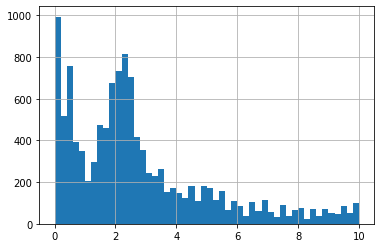

In [9]:
price_df.loc[(price_df['attr1_price']<10)&(price_df['attr1_price'] > 0), 'attr1_price'].hist(bins=50)

In [10]:
edge_df_raw['Timestamp'].describe()

count                   17371
unique                  16151
top       2021-07-30 23:16:40
freq                       86
first     2017-06-23 21:05:06
last      2021-10-09 16:22:09
Name: Timestamp, dtype: object

In [11]:
print(str(len(edge_df_raw['FromAddress'].dropna().unique())) + " addresses involved in FromAddress")
print(str(len(edge_df_raw['ToAddress'].dropna().unique())) + " addresses involved in ToAddress")
print(str(len(node_df_raw['Id'].unique())) + " addresses identified in the node data")
print(str(len(set(edge_df_raw[['FromAddress', 'ToAddress']].values.flatten())) -1) + " addresses involved in transactions")
print("-----")
print(str(len(edge_df_raw)) + ' transactions in the data')
print(str(len(edge_df_raw['asset_ID'].unique())) + " unique assets identified")


2727 addresses involved in FromAddress
4145 addresses involved in ToAddress
4806 addresses identified in the node data
4806 addresses involved in transactions
-----
17372 transactions in the data
6378 unique assets identified


In [12]:
edge_df['attr1_price'].describe()

count    17372.000000
mean         3.145970
std          7.232076
min          0.000000
25%          0.115000
50%          1.800000
75%          3.600000
max        420.000000
Name: attr1_price, dtype: float64

##### On average, how long have people got involved?

In [13]:
def count_num_days(user_id):
    ts = edge_df_raw.loc[(edge_df_raw['FromAddress'] == user_id) | (edge_df_raw['ToAddress'] == user_id), 'Timestamp']
    delta = ts.max() - ts.min()
    return delta.days

count    4806.000000
mean       92.825635
std       237.160714
min         0.000000
25%         0.000000
50%         2.000000
75%        74.000000
max      1567.000000
Name: duration, dtype: float64

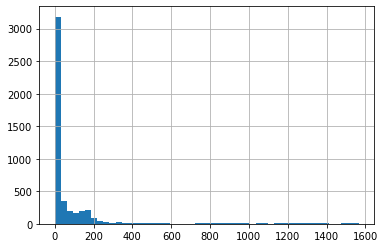

In [14]:
node_df_raw['duration'] = node_df_raw['Id'].apply(lambda r: count_num_days(r))
node_df_raw['duration'].hist(bins = 50)
node_df_raw['duration'].describe()

##### On average, how many assets have people did transactions?

In [15]:
def count_unique_asset_ID(user_id):
    assetID = edge_df_raw.loc[(edge_df_raw['FromAddress'] == user_id) | (edge_df_raw['ToAddress'] == user_id), 'asset_ID']
    return len(assetID.unique())

count    4806.000000
mean        4.968789
std        34.697232
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      2193.000000
Name: assetCount, dtype: float64

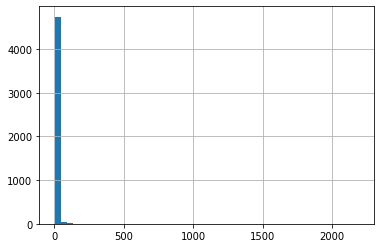

In [16]:
node_df_raw['assetCount'] = node_df_raw['Id'].apply(lambda r: count_unique_asset_ID(r))
node_df_raw['assetCount'].hist(bins = 50)
node_df_raw['assetCount'].describe()

##### On average, how many transactions were they involved?

In [17]:
def count_transaction(user_id):
    return len(edge_df_raw.loc[(edge_df_raw['FromAddress'] == user_id) | (edge_df_raw['ToAddress'] == user_id), 'asset_ID'])

count    4806.000000
mean        6.431544
std        42.640293
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      2683.000000
Name: trans_count, dtype: float64

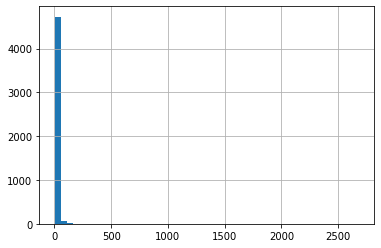

In [18]:
node_df_raw['trans_count'] = node_df_raw['Id'].apply(lambda r: count_transaction(r))
node_df_raw['trans_count'].hist(bins = 50)
node_df_raw['trans_count'].describe()

##### The number of transactions over time

In [19]:
edge_df_raw['dt_str'] = edge_df_raw['Timestamp'].apply(lambda x: str(x))

In [20]:
edge_df_raw['dt'] = edge_df_raw['dt_str'].str[:10]

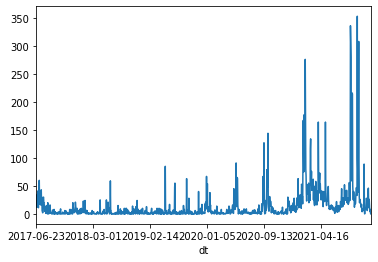

In [21]:
edge_df_raw.groupby('dt').count()['EventType'].sort_index().plot()

##### Tracking the crazy person of 420 ETH

In [22]:
edge_df_raw[edge_df_raw['attr1_price'] == edge_df_raw['attr1_price'].max()]

,FromAddress,ToAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,PaymentTokenUsd,TokenId,AssetContractAddress,AssetId,TransactionId,attr1_price,asset_ID,dt_str,dt
4161,0x03911fecabd6b4809c88e2e6eb856ec932b2ee3e,0xf4b4a58974524e183c275f3c6ea895bc2368e738,2021-03-11 00:48:39,successful,ETH,4200000000000000000000,3594.53,7804,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176783,89061015,420.0,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_7804,2021-03-11 00:48:39,2021-03-11
13039,0x6611fe71c233e4e7510b2795c242c9a57790b376,0x0000000000000000000000000000000000000000,2021-03-11 20:57:01,successful,ETH,4200000000000000000000,3594.53,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314752,420.0,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_3100,2021-03-11 20:57:01,2021-03-11


In [25]:
node_df_raw.sort_values('assetCount', ascending=False).head(11)

,Id,duration,assetCount,trans_count
13,0x0000000000000000000000000000000000000000,1567,2193,2683
75,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,859,395,515
113,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,241,352,376
229,0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a,1176,238,238
189,0x6f4a2d3a4f47f9c647d86c929755593911ee91ec,1551,221,225
52,0x269616d549d7e8eaa82dfb17028d0b212d11232a,84,195,230
133,0x1919db36ca2fa2e15f9000fd9cdc2edcf863e685,151,194,330
1351,0xa3cb30128532f43fe1c8a9f4c19422aa631307a9,1364,179,179
12,0xca8fe4acb1cb8b5550a3c71ffe2399f6c7016686,93,176,176
151,0x6611fe71c233e4e7510b2795c242c9a57790b376,1553,169,190


##### Others... finding other interesting patterns especially 0x000

In [23]:
len(edge_df_raw.loc[edge_df_raw['ToAddress']=='0x0000000000000000000000000000000000000000', 'asset_ID'].unique())

2193

In [65]:
sample_asset = edge_df_raw.loc[edge_df_raw['ToAddress']=='0x0000000000000000000000000000000000000000', 'asset_ID'].sample(1).iloc[0]
history = edge_df_raw[edge_df_raw['asset_ID'] == sample_asset].sort_values('Timestamp')
history[['FromAddress', 'ToAddress', 'Timestamp', 'attr1_price', 'asset_ID']]

,FromAddress,ToAddress,Timestamp,attr1_price,asset_ID
4022,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,0xb5696e4057b9ba76616cecb5a537eaca7b3cdf54,2021-07-31 00:52:24,2.999,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_7877
4021,0xb5696e4057b9ba76616cecb5a537eaca7b3cdf54,0x0000000000000000000000000000000000000000,2021-08-04 02:48:20,4.150,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_7877
4020,0xda24f041a3dc3beaaa1105cc47087f1566037d21,0xd12e276f76a55af8558e149b5efeb6aa3a64ee84,2021-08-23 13:05:00,7.200,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_7877


##### On average, how many people have minted something?

In [71]:
# minters = edge_df_raw['AssetContractAddress'].unique().tolist()
def count_minted_NFT(user_id):
    assetID = edge_df_raw.loc[edge_df_raw['AssetContractAddress'] == user_id, 'asset_ID'].unique()
    return len(assetID)

In [74]:
edge_df_raw['AssetContractAddress'].unique()

array(['0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb'], dtype=object)

In [75]:
edge_df_raw[edge_df_raw['FromAddress'] == '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb']

,FromAddress,ToAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,PaymentTokenUsd,TokenId,AssetContractAddress,AssetId,TransactionId,attr1_price,asset_ID,dt_str,dt,DateRank


count    4806.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: mint_count, dtype: float64

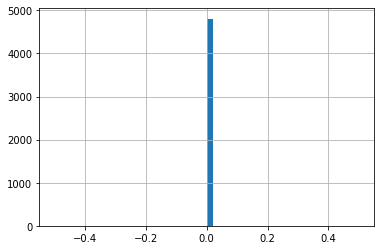

In [72]:
node_df_raw['mint_count'] = node_df_raw['Id'].apply(lambda r: count_minted_NFT(r))
node_df_raw['mint_count'].hist(bins = 50)
node_df_raw['mint_count'].describe()

In [73]:
node_df_raw.sort_values("mint_count", ascending=False)

,Id,duration,assetCount,trans_count,mint_count
0,0xee3766e4f996dc0e0f8c929954eaafef3441de87,684,94,106,0
3210,0xc41dddd3fd3788e1021868434f0e9940af52a893,35,2,3,0
3208,0x18669d73480a3301b191c7d939ba7b0a9a39a6fb,0,1,1,0
3207,0x92c4317830af63462064b9b120f9c094ba428890,0,1,1,0
3206,0x7fccd576b808736f84eabeb03b49515251049435,0,1,1,0
3205,0x01076e09dcb258c16537670307f9bdced007bf37,0,1,1,0
3204,0x019edcb493bd91e2b25b70f26d5d9041fd7ef946,0,1,1,0
3203,0xd2d628156b947751a43c1c2132f6954bb45b30b2,25,2,3,0
3202,0x534a0076fb7c2b1f83fa21497429ad7ad3bd7587,10,2,2,0
3201,0x371b699d18081912a51050d7c5ae53f69e44fcd6,0,1,1,0


In [ ]:
edge_

In [55]:
minter_IDs = first_trans['FromAddress'].unique().tolist()

In [56]:
len(minter_IDs)

378

In [66]:
edge_df_raw

,FromAddress,ToAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,PaymentTokenUsd,TokenId,AssetContractAddress,AssetId,TransactionId,attr1_price,asset_ID,dt_str,dt,DateRank
0,0xee3766e4f996dc0e0f8c929954eaafef3441de87,0x0e44370ac1ffae7655bc810f5af038444ba821cb,2021-03-05 19:45:26,successful,ETH,69960000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,87431756,6.996000e+00,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_8770,2021-03-05 19:45:26,2021-03-05,4.0
1,0xef3d9ddf59f3622a04753c61e6c4d596e7fc610d,0xee3766e4f996dc0e0f8c929954eaafef3441de87,2020-10-05 19:46:24,successful,ETH,14000000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,51189638,1.400000e+00,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_8770,2020-10-05 19:46:24,2020-10-05,3.0
2,NaN,0x7d438bf6567673867480b7923669bf349e6c8c12,2020-05-10 13:21:03,successful,ETH,2000000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,23601496,2.000000e-01,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_8770,2020-05-10 13:21:03,2020-05-10,2.0
3,NaN,0x0544fbed9b72aa036517b21d1db50201a17d09ce,2020-04-25 05:49:34,successful,ETH,1000000000000000000,3594.53,8770,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530400,19684867,1.000000e-01,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_8770,2020-04-25 05:49:34,2020-04-25,1.0
4,0xcfd9ccafc35b86299fc5617f66e89c0782bacfe0,0xef764bac8a438e7e498c2e5fccf0f174c3e3f8db,2021-08-11 04:05:28,successful,ETH,110000000000000000000,3628.90,9998,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178240,146779899,1.100000e+01,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_9998,2021-08-11 04:05:28,2021-08-11,3.0
5,0x78f0269f5b1ca914c8c58993f41181f89e212b27,0xcfd9ccafc35b86299fc5617f66e89c0782bacfe0,2021-03-03 20:01:27,successful,ETH,38000000000000000000,3628.90,9998,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178240,86759486,3.800000e+00,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_9998,2021-03-03 20:01:27,2021-03-03,2.0
6,0x73e4a2b60cf48e8baf2b777e175a5b1e4d0c2d8f,0x78f0269f5b1ca914c8c58993f41181f89e212b27,2020-12-27 00:02:55,successful,ETH,15000000000000000000,3628.90,9998,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178240,69544309,1.500000e+00,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_9998,2020-12-27 00:02:55,2020-12-27,1.0
7,0x10725af1f2919d0acc5cf294285d97710f980490,0x0e44370ac1ffae7655bc810f5af038444ba821cb,2021-02-08 13:44:37,successful,ETH,99990000000000000000,3628.90,9997,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176564,80007113,9.999000e+00,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_9997,2021-02-08 13:44:37,2021-02-08,1.0
8,0xddfdcb21c935e8432a559cf689c83695b27a4177,0x3689df917b622d8c35e01577bde8198b7e79b83d,2021-08-15 07:18:41,successful,ETH,8800000000000,3628.90,9990,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,531098,148484158,8.800000e-07,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_9990,2021-08-15 07:18:41,2021-08-15,2.0
9,0xca8fe4acb1cb8b5550a3c71ffe2399f6c7016686,0xddfdcb21c935e8432a559cf689c83695b27a4177,2021-03-20 11:18:36,successful,ETH,24500000000000000000,3628.90,9990,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,531098,92116785,2.450000e+00,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb_9990,2021-03-20 11:18:36,2021-03-20,1.0


##### On average, what's transaction amount for the account?

In [44]:
edge_df[edge_df['to_node'] == '0xee3766e4f996dc0e0f8c929954eaafef3441de87'].count()

from_node       8
to_node        12
attr1_price    12
asset_ID       12
dtype: int64

In [ ]:
edge_df_

In [ ]:
# Dropping unnecessary columns
edge_df = edge_df.drop(['EventType', 'PaymenTokenSymbol'])
